In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import scanpy as sc
from tqdm import tqdm

import sys
#show the pass to chocolat module
sys.path.append('../')
plt.rcParams['pdf.fonttype'] = 42

In [2]:
# Load filtered anndata objects

filtered_anndata_folder = '../data/filtered-anndata'
file_list = os.listdir(filtered_anndata_folder)

adata_dict_filtered = {}
for file in file_list:
    if file.endswith('.h5ad'):
        ref_code = file[:-5]  # Remove the '.h5ad' extension
        
        filepath = os.path.join(filtered_anndata_folder, file)
        adata = sc.read_h5ad(filepath)
        adata.obsm['spatial'] = adata.obsm['spatial'].astype(int) # To ensure spatial coordinates are numerical
        adata_dict_filtered[ref_code] = adata

In [3]:
# Load plasmid encoding table

plasmids_df = pd.read_csv('../data/plasmid_code.csv')
plasmids_matrix = pd.pivot_table(plasmids_df, index='List', columns='Name', values='FeatureType',
                                 aggfunc=lambda x: 1, fill_value=0)
reporters = list(plasmids_matrix.columns)

plasmids_ordered_list = ['MYC-plasmid', 'mtCtnnb1', 'coVEGFA-plasmid',
                         'shMLL3-plasmid', 'NICD-plasmid', 'shRen-plasmid', 'shtrp53-plasmid', 'shPTEN-plasmid']

colours = {
    "MYC-plasmid": "#56b4e9",  # Blue
    "coVEGFA-plasmid": "#cc79a7",  # Orange
    "NICD-plasmid": "#e69f00",  # Green
    "shRen-plasmid": "#f0e442",  # Red
    "shtrp53-plasmid": "#d55e00",  # Purple
    "shPTEN-plasmid" : "#009e73",  # Brown
    "shMLL3-plasmid": "#0072b2",  # Pink
    "mtCtnnb1": "#000000",  # Grey
}

In [4]:
# Load inferred perturbations probability posteriors

# Load saved model samples
with open('../data/model_outputs/samples_genotyping_model.npy', 'rb') as file:
    samples_dict = np.load(file, allow_pickle=True).item()

## Converting plasmid probability into genotype probability

In [5]:
from chocolat.models import get_sample_prior_parametrisation, prepare_data4genotype_models
from chocolat.statsmodel import genotype_prob, resample_population, marginal_frequency, compute_odds_ratio_plasmids
from matplotlib.colors import LinearSegmentedColormap

/lustre/scratch127/casm/team299ly/al15/miniconda3/envs/chocolat-g2p/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
def adjust_colormap_vibrancy(colors, vibrancy_factor=1):
    adjusted_colors = np.copy(colors)
    adjusted_colors[:, 1] *= 0.9 
    adjusted_colors[:, 0] *= 0.9  
    adjusted_colors[:, 2] *= 0.6
    adjusted_colors[:, :3] = np.clip(adjusted_colors[:, :3] * vibrancy_factor, 0, 1)
    return adjusted_colors

# Generate the adjusted colormap
num_colors = 256
colors = plt.cm.rainbow(np.linspace(0, 1, num_colors))
adjusted_colors = adjust_colormap_vibrancy(colors)
custom_vibrant_cmap = LinearSegmentedColormap.from_list("adjusted_colors", adjusted_colors, N=num_colors)

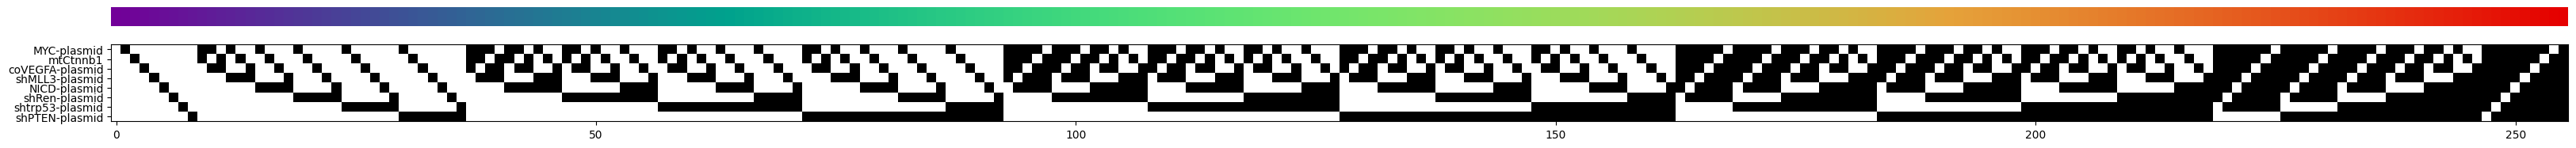

In [7]:
combs = np.array([list(np.binary_repr(i, width=8)) for i in range(256)], dtype=int)
# # Sort the combinations
sorted_combinations = np.array(sorted(combs, key=lambda x: (sum(x), tuple(x))))

fig,axs = plt.subplots(2, 1, figsize=(40,2), gridspec_kw={'height_ratios': (1,5)})
axs[0].imshow(np.array([np.zeros(256), np.arange(256), np.arange(256)]), cmap=custom_vibrant_cmap)
axs[0].set_ylim(0.5,2.5)
axs[0].axis('off')
axs[0].set_aspect('auto')
axs[1].imshow(sorted_combinations.T[::-1], cmap='Greys')
axs[1].set_yticks(np.arange(8));
axs[1].set_yticklabels(plasmids_ordered_list);

In [8]:
keys_6ROI = ['ML_III_A', 'ML_III_B', 'ML_II_A_1',
           'ML_II_B',
           'ML_II_C', 'ML_I_2']

data, umi, region_ids_tensor, plasmid_matrix_tensor = prepare_data4genotype_models(adata_dict_filtered, reporters, plasmids_matrix.values,
                                                                                  region_id_column='histo_annotation_num',
                                                                                  keys=keys_6ROI,
                                                                                  device='cpu')

Prepared data for the following samples: 
ML_III_A, ML_III_B, ML_II_A_1, ML_II_B, ML_II_C, ML_I_2


In [9]:
sorted_combinations.shape

(256, 8)

In [10]:
plasmid_probs_beta_stacked = []
for key in keys_6ROI:
    prior_parametrisation_dict = get_sample_prior_parametrisation(samples_dict[key])

    plasmid_probs_beta_params = np.array(prior_parametrisation_dict['region_params'])[:,:,::-1]

    genotype_probs = genotype_prob(plasmid_probs_beta_params,
                                   sorted_combinations)

    ar = np.zeros(adata_dict_filtered[key].obs.shape[0]) * np.nan
    ar_p = np.zeros(adata_dict_filtered[key].obs.shape[0]) * np.nan
    max_likely_genotype = np.argmax(genotype_probs,0)
    p_max_genotype = np.max(genotype_probs,0)
    for i in range(genotype_probs.shape[1]):
        ar[region_ids_tensor[key].numpy() == i] = max_likely_genotype[i]
        ar_p[region_ids_tensor[key].numpy() == i] = p_max_genotype[i]

    adata_dict_filtered[key].obs.loc[:,'genotype_id'] = ar
    adata_dict_filtered[key].obs.loc[:,'genotype_prob'] = ar_p
    plasmid_probs_beta_stacked.append(plasmid_probs_beta_params)
    
plasmid_probs_beta_stacked = np.concatenate(plasmid_probs_beta_stacked, axis=1)
# get a simulated population
prob_1, simulated_genotypes = resample_population(plasmid_probs_beta_stacked, n_samples=5000)

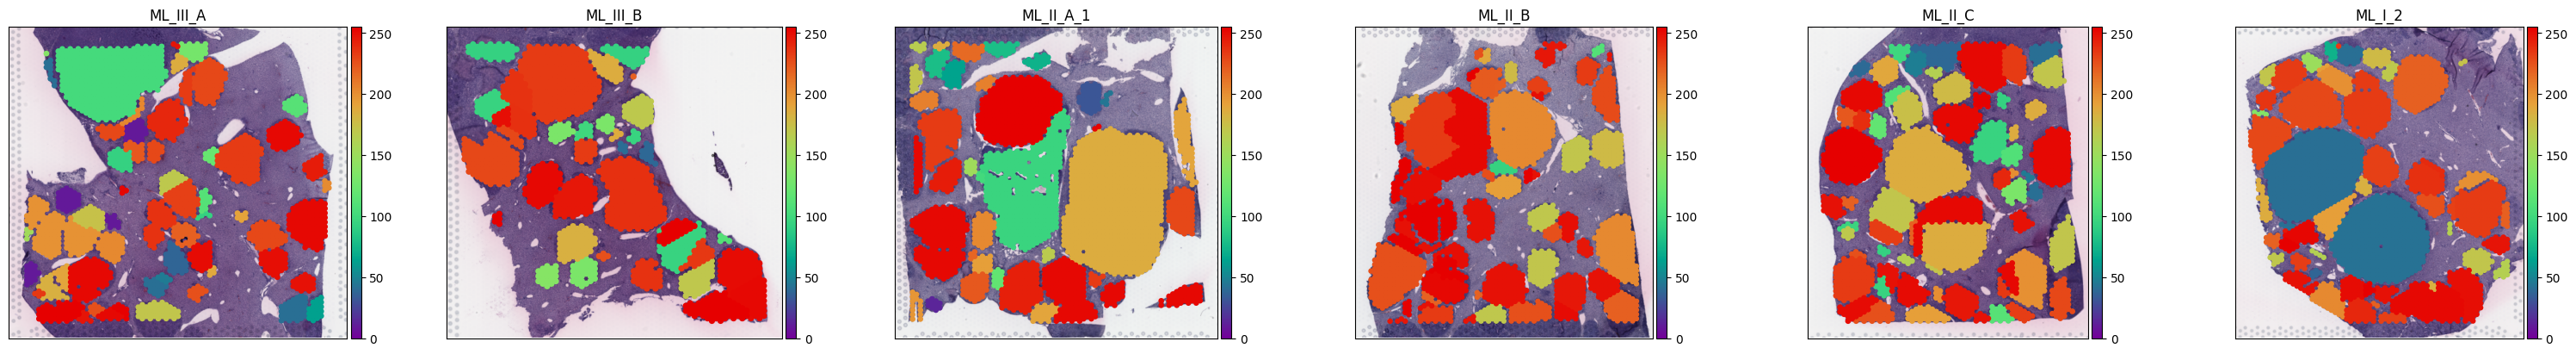

In [11]:
fig = plt.figure(layout='constrained', figsize=(30,4))
subfigs = fig.subfigures(1, 6, wspace=0.07)

for i, key in enumerate(keys_6ROI):
    ax = subfigs.flatten()[i].subplots(1, 1, sharey=True)
    ad = adata_dict_filtered[key]
    ad = ad[~((ad.obs['histo_annotation'] == 'normal_tissue') |
        ([x.startswith("Normal") for x in ad.obs['histo_annotation']]))]
    sc.pl.spatial(ad, img_key='lowres',
                  color=['genotype_id'],
                  cmap=custom_vibrant_cmap, vmin=0, ax=ax, show=False, spot_size=250)
    ax.set_title(key)
    ax.set_xlabel('')
    ax.set_ylabel('')

## Global statistics

100%|██████████████████████████████████████████████████████████████████| 5000/5000 [00:50<00:00, 98.04it/s]


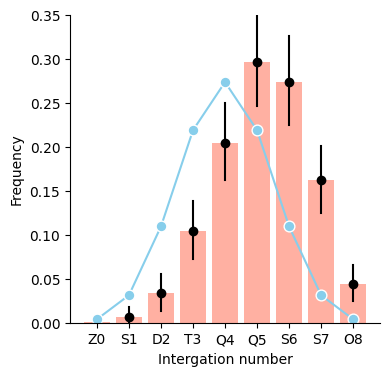

In [12]:
import scipy.stats as st
ps = marginal_frequency(simulated_genotypes, axis=0, rep_axis=1, bins=9)
    
plt.figure(figsize=(4,4))
for i in range(9):
    plt.bar(i, np.mean(np.array(ps)[:,i]), color='tomato', alpha=0.5)
    plt.scatter(i, np.mean(np.array(ps)[:,i]), c='k')
    plt.plot([i,i], [np.percentile(np.array(ps)[:,i], 2.5), np.percentile(np.array(ps)[:,i], 97.5)], c='k')

plt.scatter(np.arange(9), st.binom(n=8, p=0.5).pmf(np.arange(9)), s=60, c='skyblue', edgecolor='white',zorder=2)
plt.plot(np.arange(9), st.binom(n=8, p=0.5).pmf(np.arange(9)), c='skyblue',zorder=1)

plt.ylim(0,0.35)
plt.xticks(np.arange(9), ['Z0', 'S1', 'D2', 'T3', 'Q4', 'Q5', 'S6', 'S7', 'O8'])
plt.gca().spines[['right', 'top']].set_visible(False)
plt.ylabel('Frequency')
plt.xlabel('Intergation number')
plt.show()

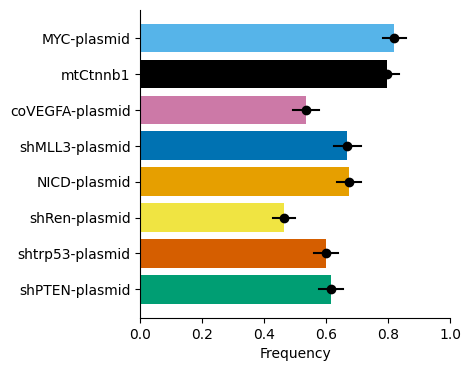

In [13]:
plt.figure(figsize=(4,4))

for i in range(8):
    s = np.random.binomial(1,np.repeat(prob_1[None,:,7-i], 5000, axis=0)).mean(1)
    plt.barh(np.arange(8)[i], np.mean(s), color=colours[plasmids_ordered_list[i]], alpha=1)
    plt.scatter(np.mean(s), np.arange(8)[i], c='k')
    plt.plot([np.percentile(s, 2.5), np.percentile(s, 97.5)], [np.arange(8)[i],np.arange(8)[i]], c='k')
plt.gca().invert_yaxis()
plt.xlim(0,1)
plt.gca().spines[['right', 'top']].set_visible(False)
plt.yticks(np.arange(8), plasmids_ordered_list);
plt.xlabel('Frequency')
plt.show()

## Epistasis

In [14]:
from chocolat.statsmodel import plot_epistatic_effect_glm, plot_epistatic_effect_torch

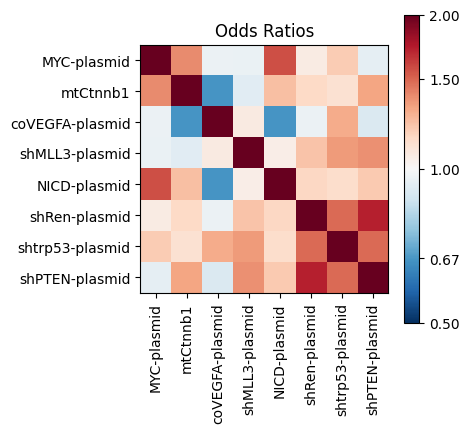

In [15]:
log_odds_matrix = compute_odds_ratio_plasmids(prob_1)

plt.figure(figsize=(4,4))
plt.imshow(log_odds_matrix, cmap='RdBu_r', vmin=-0.3, vmax=0.3)
cbar = plt.colorbar()
# Adjust colorbar labels to real scale
ticks = [-0.3, -0.175, 0, 0.175, 0.3]#np.linspace(-0.3, 0.3, num=5) # Generates 5 tick marks from vmin to vmax
real_scale_ticks = [f"{10**tick:.2f}" for tick in ticks] # Converts to real scale
cbar.set_ticks(ticks)
cbar.set_ticklabels(real_scale_ticks)
plt.xticks(np.arange(len(plasmids_ordered_list)), np.array(plasmids_ordered_list), rotation=90)
plt.yticks(np.arange(len(plasmids_ordered_list)), np.array(plasmids_ordered_list))
plt.title('Odds Ratios')
plt.show()


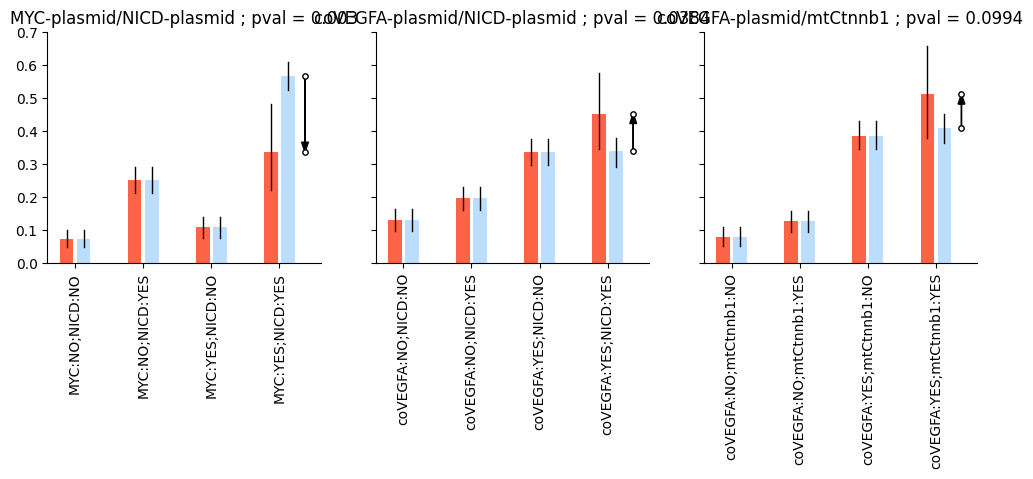

In [16]:
fig, ax = plt.subplots(1,3,figsize=(12, 3), sharey=True)
plot_epistatic_effect_glm(simulated_genotypes, -1, -5, plasmids_ordered_list, ax=ax[0])
plot_epistatic_effect_glm(simulated_genotypes, -3, -5, plasmids_ordered_list, ax=ax[1])
plot_epistatic_effect_glm(simulated_genotypes, -3, -2, plasmids_ordered_list, ax=ax[2])

## Individual Genotypes

In [17]:
from chocolat.statsmodel import compute_observed_genotypes_probability, hdpi_sim_genotypes_counts, simulate_hnull_genotype_probability
from chocolat.statsmodel import dif_sim_genotypes
from chocolat.plt import blend_color
import matplotlib.colors as mcolors

In [18]:
observed_genotype_probability = compute_observed_genotypes_probability(prob_1, sorted_combinations, n_samples=5000)
hdpis = hdpi_sim_genotypes_counts(observed_genotype_probability, n_samples=1000, p=5)

100%|████████████████████████████████████████████████████████████████████| 256/256 [00:12<00:00, 21.23it/s]


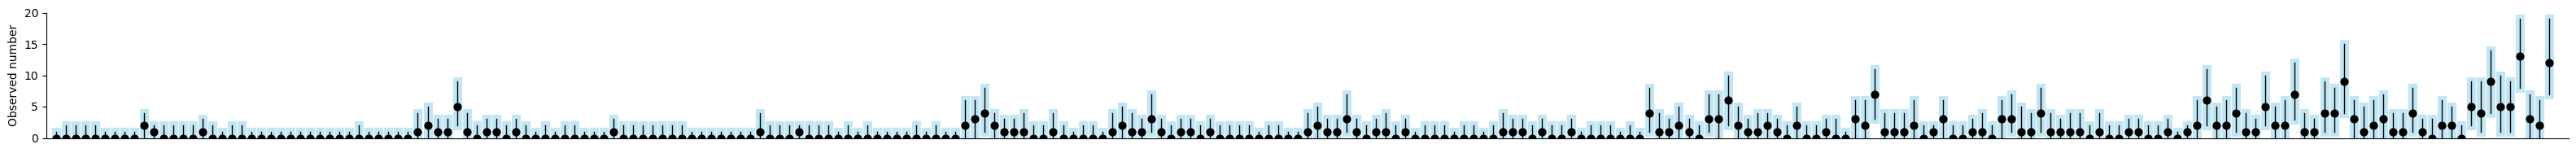

In [19]:
plt.figure(figsize=(40,2))
plt.scatter(np.arange(256), hdpis[:,0], s=40, zorder=5, edgecolor='k', color='k')
plt.plot([np.arange(256), np.arange(256)], [hdpis[:,1], hdpis[:,2]], c='skyblue', lw=8, linestyle='-', alpha=0.5);
plt.plot([np.arange(256), np.arange(256)], [hdpis[:,1], hdpis[:,2]], c='k', lw=1, linestyle='-');
plt.gca().get_xaxis().set_visible(False)
plt.gca().spines[['right', 'top']].set_visible(False)
plt.xlim(-1,257)
plt.ylim(0,20)
plt.ylabel('Observed number')
plt.show()

In [20]:
hnull_genotype_probability = simulate_hnull_genotype_probability(prob_1, ref_genotype_table=sorted_combinations, n_samples=5000)
dif_array = dif_sim_genotypes(observed_genotype_probability, hnull_genotype_probability)

100%|███████████████████████████████████████████████████████████████████| 256/256 [00:02<00:00, 126.33it/s]


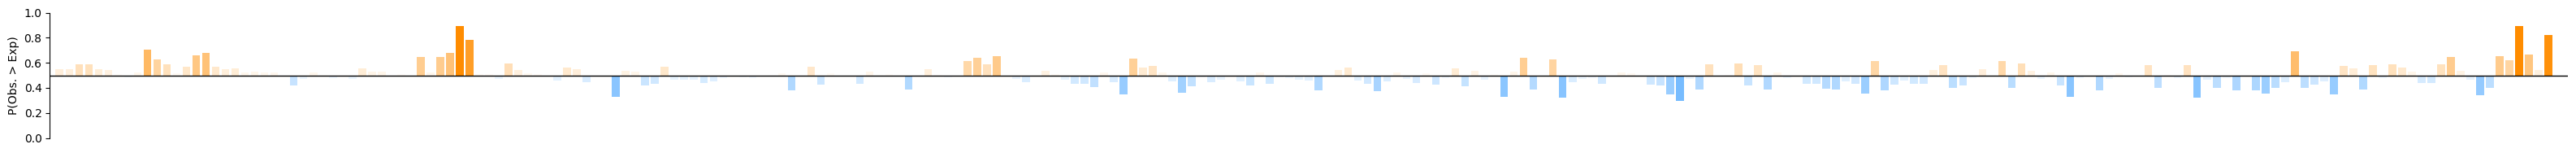

In [21]:
c = ['darkorange' if x > 0.5 else 'dodgerblue' for x in dif_array]
plt.figure(figsize=(40,2))

for i in range(256):
    blend_factor = 1 - np.minimum((np.abs(dif_array[i] - 0.5) * 3), 1)
    rgb_color = mcolors.to_rgb(c[i])
    blended_color = blend_color(rgb_color, [1, 1, 1], blend_factor)
    # plt.plot([np.arange(256)[i], np.arange(256)[i]], [0.5, np.array(ar_bigger)[i]], color=blended_color, lw=7)
    plt.bar(np.arange(256)[i], np.array(dif_array)[i]-0.5, bottom=0.5,
            color=blended_color, width=0.8)
    # plt.scatter(np.arange(256)[i], np.array(ar_bigger)[i], color=blended_color, s=80)
plt.axhline(0.5, c='k', lw=1)
plt.ylabel('P(Obs. > Exp)')
plt.ylim(0,1)
plt.xlim(-1,257)
plt.gca().get_xaxis().set_visible(False)
plt.gca().spines[['right', 'top', 'bottom']].set_visible(False)
